# Pairs Trading

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/y1/h3rdxlrj2qvdwwjh6r3b721m0000gp/T/ipykernel_18832/3337317322.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.params[0]
/var/folders/y1/h3rdxlrj2qvdwwjh6r3b721m0000gp/T/ipykernel_18832/3337317322.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['spread'] = df.TCS - model.params[0] * df.INFY


INFY    2.972775
dtype: float64


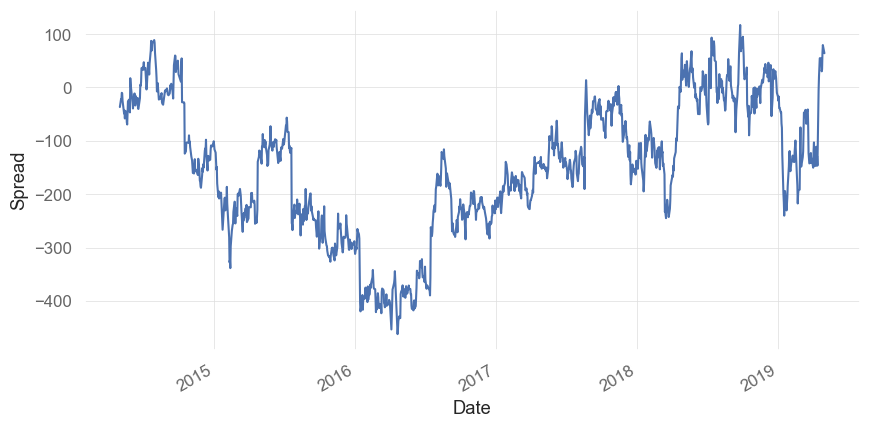

-2.7494786345827795
{'1%': -3.435690695421723, '5%': -2.863898416697677, '10%': -2.5680256555204184}


/var/folders/y1/h3rdxlrj2qvdwwjh6r3b721m0000gp/T/ipykernel_18832/3337317322.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.positions_long = df.positions_long.fillna(method='ffill')
/var/folders/y1/h3rdxlrj2qvdwwjh6r3b721m0000gp/T/ipykernel_18832/3337317322.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.positions_short = df.positions_short.fillna(method='ffill')
[*********************100%%**********************]  1 of 1 completed
/Users/tdafonseca/Desktop/6-Github/learning/portfolio-optimization/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis,

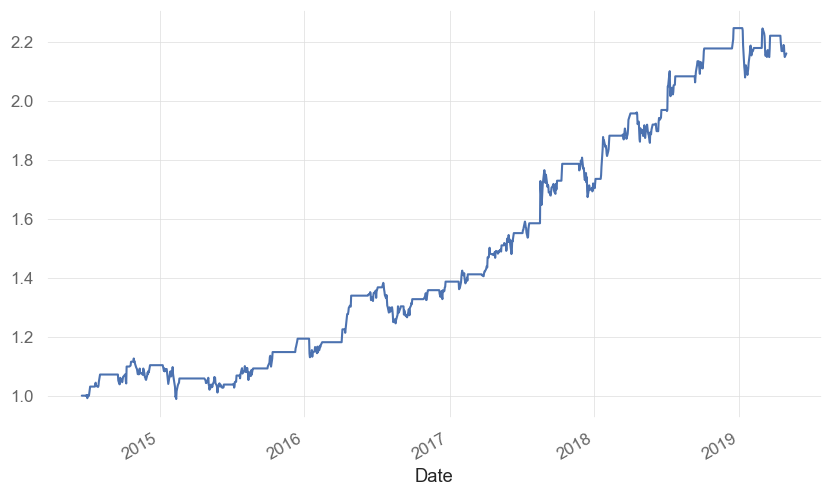

In [1]:

import quantstats as qs
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
#improrting statsmodel to import linear regession with the error as ordinary least square method
from statsmodels.api import OLS
#Importing stats model to calculate adffuller
from statsmodels.tsa.stattools import adfuller
pd.set_option('display.max_rows', 50)
%matplotlib inline

## Fetching Daily data using yahoo-finance

#downloading TCS data from yahoo finance API
df_1 = yf.download('TCS.NS',start='2014-05-01', end = '2019-05-01')['Adj Close']
#downloading INFY data from yahoo finance API
df_2 = yf.download('INFY.NS',start='2014-05-01',end = '2019-05-01')['Adj Close']

#merging two dataframe using the datetime index
df = pd.merge(df_1,df_2,left_index=True, right_index=True)

#renaming the columns
df.columns = ['TCS','INFY']


#using linear regression to calculate the relation of price between TCS and INFY
model = OLS(df.TCS.iloc[:100], df.INFY.iloc[:100])
model = model.fit()

#slope of linear regression which will be the coefficient
model.params[0]

#finding the value of spread between TCS and INFY
df['spread'] = df.TCS - model.params[0] * df.INFY

#Now we will check that this spread is a stationary time-series or not?
#We will use ADF-Fuller test to check this hypothesis

#plotting the time-series
print(model.params)
# Plot the spread
df.spread.plot(figsize=(10,5))
plt.ylabel("Spread")
plt.show()


#Putting maximum lag as 1
adf = adfuller(df.spread, maxlag=1)

#Value of ADF fuller test
print(adf[0])
print(adf[4])

#Here we can see that -2.86 < -2.7494 < -2.568
#So we are more than 90% confidence interval that our price is stationary

#Calculating moving averages and Standard deviation
# Moving Average
df['moving_average'] = df.spread.rolling(30).mean()
# Moving Standard Deviation
df['moving_std_dev'] = df.spread.rolling(30).std()

#calculating moving average of upper bound and lower bound
df['upper_band'] = df.moving_average + 2*df.moving_std_dev
df['lower_band'] = df.moving_average - 2*df.moving_std_dev

#finding long entries and Long exits
df['long_entry'] = df.spread < df.lower_band
df['long_exit'] = df.spread >= df.moving_average

#Segragating long entries and exits in dataframe
df['positions_long'] = np.nan
df.loc[df.long_entry,'positions_long']= 1
df.loc[df.long_exit,'positions_long']= 0

df.positions_long = df.positions_long.fillna(method='ffill')

#Finding short entries
df['short_entry'] = df.spread > df.upper_band
df['short_exit'] = df.spread <= df.moving_average

#Finding short entries and exits in datframe
df['positions_short'] = np.nan
df.loc[df.short_entry,'positions_short']= -1
df.loc[df.short_exit,'positions_short']= 0

df.positions_short = df.positions_short.fillna(method='ffill')

#Net positions
df['positions'] = df.positions_long + df.positions_short

#Finding pnl and spread analysis
#df['spread_difference']= df.spread - df.spread.shift(1)
df['spread_difference_pct_change'] = (df.spread - df.spread.shift(1))/(df.TCS + df.INFY)
df['pnl_daily_pct'] = df.positions.shift(1) * df.spread_difference_pct_change
#df['cumpnl'] = df.pnl.cumsum()

df = df.dropna(subset=['pnl_daily_pct'])

df['cummulative'] = (1 + df['pnl_daily_pct']).cumprod()
df['cummulative'].plot()

#importing quantstats for detailed report
df_returns = df[['pnl_daily_pct']]
df_returns

tickers = {
        'pnl_daily_pct':1
    }

portfolio = qs.utils.make_index(tickers,rebalance=None,returns=df_returns)

qs.reports.html(portfolio,benchmark='^CRSLDX',title='Pairs-Trading(XumitCapital)', download_filename='Pairs _Trading.html',)